In [1]:
# Barış Nişancı
# 20070001019
# SE4475_ASSIGNMENT

In [2]:
# ==========================
# Text Processing and Library Initialization
# ==========================
# This section sets up the necessary tools for handling Turkish text data and machine learning tasks.
# Zemberek, a library for Turkish Natural Language Processing, is used to analyze and process Turkish words.
# Additionally, libraries for text encoding detection, data manipulation, and machine learning are imported.
# The initialization ensures that text can be read, cleaned, and prepared for further analysis.

In [3]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import jpype
import chardet
from jpype.imports import registerDomain

# saving path of .jar file for zemberek library
zemberek_path = "libs/zemberek-full.jar"

# I started the JVM for zemberek because .jar file can't run on python
if not jpype.isJVMStarted():
    jpype.startJVM(classpath=[zemberek_path])

registerDomain("zemberek", alias="zemberek")
from zemberek.morphology import TurkishMorphology

# Initialize Zemberek for Turkish morphological analysis
morphology = TurkishMorphology.createWithDefaults()


In [4]:
# ==========================
# Turkish Text Preprocessing
# ==========================
# This section cleans and prepares Turkish text for analysis.
# - Fixes corrupted characters.
# - Removes stop-words.
# - Tokenizes and stems words using Zemberek.
# The result is clean, standardized text data ready for machine learning.

In [5]:
from nltk.corpus import stopwords
import os
import chardet
import jpype
from zemberek.morphology import TurkishMorphology
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# I check if JVM started
zemberek_jar_path = "libs/zemberek-full.jar"  # Zemberek'in JAR dosya yolu
if not jpype.isJVMStarted():
    jpype.startJVM(classpath=[zemberek_jar_path])
    

# Function to fix corrupted Turkish characters (e.g., 'ð' to 'ğ')
def fix_turkish_characters(text):
    char_map = {'ð': 'ğ', 'ý': 'ı', 'þ': 'ş', 'Þ': 'Ş', 'Ð': 'Ğ', 'Ý': 'İ'}
    for wrong, correct in char_map.items():
        text = text.replace(wrong, correct)
    return text

# Stemming
# Function to extract the root (stem) of a Turkish word using Zemberek
def stem_word(word):
    analysis = morphology.analyzeSentence(word)
    results = morphology.disambiguate(word, analysis).bestAnalysis()
    return " ".join([str(result.getStem()) for result in results])

# TOKENIZATION
# Function to preprocess text (fix characters, tokenize, remove stop-words, stem words)
def preprocess_text(text, stop_words):
    # Fix Turkish characters and convert text to lowercase
    text = fix_turkish_characters(text).lower()
    words = word_tokenize(text)  # Tokenize by splitting on whitespace
    # Remove stop-words and stem each word
    processed_words = [stem_word(word) for word in words if word not in stop_words]
    return " ".join(processed_words)

# Function to read a file with proper encoding detection
def read_file_with_encoding(file_path):
    with open(file_path, 'rb') as file:
        raw_data = file.read()
        encoding = chardet.detect(raw_data)['encoding']
    try:
        with open(file_path, 'r', encoding=encoding) as file:
            return file.read()
    except UnicodeDecodeError:
        print(f"Cannot decode {file_path} with encoding {encoding}")
        return None

# Load Turkish Stop-words
stop_words = set(stopwords.words('turkish'))

# Define the directory containing the dataset and class folders
data_dir = "data/raw_texts"
classes = ["1", "2", "3"]

data = []  # Store processed text data
labels = []  # Store class labels

# Iterate over each class folder and preprocess text files
for idx, class_name in enumerate(classes):
    folder_path = os.path.join(data_dir, class_name)
    if not os.path.exists(folder_path):
        print(f"Path not found: {folder_path}")
        continue
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        content = read_file_with_encoding(file_path)  # Read the file
        if content:
            processed_content = preprocess_text(content, stop_words)
            data.append(processed_content)
            labels.append(idx)  # Assign the class label
            print(f"Original Text: {content.strip()}")
            print(f"Processed Text: {processed_content}")
            print("-" * 50)  # Separator for readability


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Deder\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Deder\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Original Text: dun Turkcelle tepkilerimizden sonra bugün Turkcell twittera sponsor olmuþ. Ne tesadüf deðil mi ? :)
Processed Text: dun turkcell tepki sonra bugün turkcell twitter sponsor ol . tesadüf değil mi ? : )
--------------------------------------------------
Original Text: girmezmiyim.. Turkcell kartim bile var.. Yarindan itibaren onu takicam.. Twittersiz denedim sadece 3 gun yapabildim:)))))
Processed Text: girmezmiyim . . turkcell kartim bile var . . yarindan itibaren o takicam . . twittersiz dene sadece 3 gun yap : ) ) ) ) )
--------------------------------------------------
Original Text: tam tünelden gecerken 3g cekiyordu:D türkcell'in reklamlari vodafone' harekete gecirmis olmali:)
Processed Text: tam tünel gecerken 3g cekiyordu : d türkcell reklamlari vodafone ' hareket gecirmis olmali : )
--------------------------------------------------
Original Text: turkcell superonline fiber internet veya ADSL ve sabit telefon hizmetleri
Processed Text: turkcell superonline fiber in

In [6]:
# ==========================
# TF-IDF Matrix Creation
# ==========================
# Converts preprocessed text into a numerical TF-IDF representation.
# - Captures term importance across documents.
# - Saves the TF-IDF matrix as a CSV file for further use.
# Output: A structured table with documents and term weights.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Create a TF-IDF vectorizer with a maximum of 10000 features (Current dataset has approximately 7400)
vectorizer = TfidfVectorizer(max_features=10000, min_df=1, stop_words=None)

# Transform the processed text data into a TF-IDF matrix
X_tfidf = vectorizer.fit_transform(data)
print(f"TF-IDF Matrix Size: {X_tfidf.shape}")  # Check Matrix size

# Fix Turkish characters in feature names
feature_names = vectorizer.get_feature_names_out()
fixed_feature_names = [fix_turkish_characters(name) for name in feature_names]

# Convert the TF-IDF matrix to a Pandas DataFrame
tfidf_data = X_tfidf.toarray()
tfidf_df = pd.DataFrame(tfidf_data, columns=fixed_feature_names)

# Add document names and class labels to the DataFrame
tfidf_df.insert(0, "Document", [f"doc{i+1}" for i in range(len(data))])
tfidf_df['Class'] = labels

# Save the TF-IDF DataFrame to a CSV file
tfidf_df.to_csv("tfidf_output.csv", index=False, encoding="utf-8")
print("TF-IDF Table 'tfidf_output.csv' has been saved.")


TF-IDF Matrix Size: (3000, 7409)
TF-IDF Table 'tfidf_output.csv' has been saved.


In [11]:
# ==========================
# k-Nearest Neighbors (k-NN)
# ==========================
# Implements k-NN for classification:
# - Calculates cosine similarity to find neighbors.
# - Predicts document classes based on majority vote from neighbors.
# Output: Predicted classes for test documents.

# ==========================
# Performance Evaluation
# ==========================
# Evaluates k-NN predictions using metrics:
# - Precision, Recall, F1-Score for each class.
# - Macro and Micro Averages for overall performance.
# Ensures a thorough assessment of the classifier's effectiveness.

# ==========================
# Performance Visualization
# ==========================
# Plots Accuracy, Precision, Recall, and F1-Score against k values.
# - Provides a visual comparison of metrics.
# - Saves the graph as an image file for reporting.

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

# Calculating the cosine similarity distance
def cosine_distance(X_test, X_train):
    norms_test = np.linalg.norm(X_test, axis=1, keepdims=True)
    norms_train = np.linalg.norm(X_train, axis=1, keepdims=True)
    similarity = np.dot(X_test, X_train.T) / (norms_test * norms_train.T + 1e-9)
    return 1 - similarity

# k-NN algorithm
def knn(X_train, y_train, X_test, k):
    distances = cosine_distance(X_test, X_train)
    predictions = []
    for dist in distances:
        top_k_indices = np.argsort(dist)[:k]
        top_k_classes = y_train[top_k_indices]
        predictions.append(np.bincount(top_k_classes).argmax())
    return np.array(predictions)

# Performance metrics (TP, FP, FN, Precision, Recall, F1)
def calculate_metrics(y_true, y_pred, num_classes):
    metrics = {"TP": [], "FP": [], "FN": [], "Precision": [], "Recall": [], "F1-Score": []}
    for class_idx in range(num_classes):
        TP = np.sum((y_true == class_idx) & (y_pred == class_idx))
        FP = np.sum((y_true != class_idx) & (y_pred == class_idx))
        FN = np.sum((y_true == class_idx) & (y_pred != class_idx))
        Precision = TP / (TP + FP) if TP + FP > 0 else 0
        Recall = TP / (TP + FN) if TP + FN > 0 else 0
        F1 = 2 * Precision * Recall / (Precision + Recall) if Precision + Recall > 0 else 0

        metrics["TP"].append(TP)
        metrics["FP"].append(FP)
        metrics["FN"].append(FN)
        metrics["Precision"].append(Precision)
        metrics["Recall"].append(Recall)
        metrics["F1-Score"].append(F1)

    return metrics

# Stratified 10-Fold Cross-Validation
y = np.array(labels)  # Classes
X = X_tfidf.toarray()  # TF-IDF data

num_classes = len(np.unique(y))
skf = StratifiedKFold(n_splits=10)
best_k = None
best_f1 = 0
final_metrics = {}

results = []
for k in range(1, 6):  # k=1 to k=5
    fold_metrics = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Prediction with k-NN
        y_pred = knn(X_train, y_train, X_test, k)

        # Performance metrics
        metrics = calculate_metrics(y_test, y_pred, num_classes)
        fold_metrics.append(metrics)

    avg_metrics = {
        "TP": np.mean([fold["TP"] for fold in fold_metrics], axis=0),
        "FP": np.mean([fold["FP"] for fold in fold_metrics], axis=0),
        "FN": np.mean([fold["FN"] for fold in fold_metrics], axis=0),
        "Precision": np.mean([fold["Precision"] for fold in fold_metrics], axis=0),
        "Recall": np.mean([fold["Recall"] for fold in fold_metrics], axis=0),
        "F1-Score": np.mean([fold["F1-Score"] for fold in fold_metrics], axis=0),
    }

    # Macro average
    macro_avg = {
        "Precision": np.mean(avg_metrics["Precision"]),
        "Recall": np.mean(avg_metrics["Recall"]),
        "F1-Score": np.mean(avg_metrics["F1-Score"]),
    }

    # Micro average
    micro_precision = np.sum(avg_metrics["TP"]) / (np.sum(avg_metrics["TP"]) + np.sum(avg_metrics["FP"]))
    micro_recall = np.sum(avg_metrics["TP"]) / (np.sum(avg_metrics["TP"]) + np.sum(avg_metrics["FN"]))
    micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall)
    micro_avg = {
        "Precision": micro_precision,
        "Recall": micro_recall,
        "F1-Score": micro_f1,
    }

    # Best k value
    if macro_avg["F1-Score"] > best_f1:
        best_f1 = macro_avg["F1-Score"]
        best_k = k
        final_metrics = {
            "k": k,
            "avg_metrics": avg_metrics,
            "macro_avg": macro_avg,
            "micro_avg": micro_avg,
        }
        
    # Save the result according to k
    results.append({
        "k": k,
        "accuracy": np.mean([accuracy_score(y_test, knn(X_train, y_train, X_test, k)) for train_index, test_index in skf.split(X, y)]),
        "precision": macro_avg["Precision"],
        "recall": macro_avg["Recall"],
        "f1_score": macro_avg["F1-Score"],
    })

    
# Printing for best k value and performance
best_result = max(results, key=lambda x: x["f1_score"])
print(f"Best k: {best_result['k']}")
print(f"Accuracy: {best_result['accuracy']:.4f}")
print(f"Precision: {best_result['precision']:.4f}")
print(f"Recall: {best_result['recall']:.4f}")
print(f"F1-Score: {best_result['f1_score']:.4f}")
    
    
# Print as table format
report_data = {
    "Metric": [
        "Precision",
        "Recall",
        "F1-Score",
        "Total no. of True Positive records",
        "Total no. of False Positive records",
        "Total no. of False Negative records",
    ],
    "Class 1": [
        final_metrics["avg_metrics"]["Precision"][0],
        final_metrics["avg_metrics"]["Recall"][0],
        final_metrics["avg_metrics"]["F1-Score"][0],
        final_metrics["avg_metrics"]["TP"][0],
        final_metrics["avg_metrics"]["FP"][0],
        final_metrics["avg_metrics"]["FN"][0],
    ],
    "Class 2": [
        final_metrics["avg_metrics"]["Precision"][1],
        final_metrics["avg_metrics"]["Recall"][1],
        final_metrics["avg_metrics"]["F1-Score"][1],
        final_metrics["avg_metrics"]["TP"][1],
        final_metrics["avg_metrics"]["FP"][1],
        final_metrics["avg_metrics"]["FN"][1],
    ],
    "Class 3": [
        final_metrics["avg_metrics"]["Precision"][2],
        final_metrics["avg_metrics"]["Recall"][2],
        final_metrics["avg_metrics"]["F1-Score"][2],
        final_metrics["avg_metrics"]["TP"][2],
        final_metrics["avg_metrics"]["FP"][2],
        final_metrics["avg_metrics"]["FN"][2],
    ],
    "MACRO Average": [
        final_metrics["macro_avg"]["Precision"],
        final_metrics["macro_avg"]["Recall"],
        final_metrics["macro_avg"]["F1-Score"],
        "-", "-", "-",
    ],
    "MICRO Average": [
        final_metrics["micro_avg"]["Precision"],
        final_metrics["micro_avg"]["Recall"],
        final_metrics["micro_avg"]["F1-Score"],
        "-", "-", "-",
    ],
}

# Convert the table into DataFrame
report_df = pd.DataFrame(report_data)

# Saving CSV
header_text = f"Best results of k-NN obtained by:,k = {best_k}, similarity metric: Cosine Similarity\n"
with open("knn_report.csv", "w") as f:
    f.write(header_text)
    report_df.to_csv(f, index=False)
print("Report saved as 'knn_report.csv'")


Best k: 4
Accuracy: 0.4633
Precision: 0.4997
Recall: 0.5021
F1-Score: 0.4859
Report saved as 'knn_report.csv'


In [10]:
# ==========================
# Performance Visualization
# ==========================
# Plots Accuracy, Precision, Recall, and F1-Score against k values.
# - Provides a visual comparison of metrics.
# - Saves the graph as an image file for reporting.

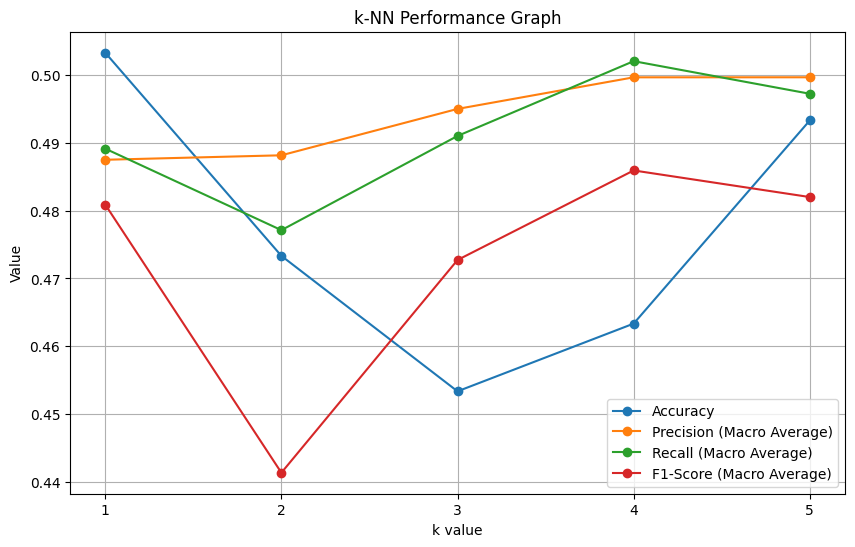

Performance Graph saved as 'knn_performance_plot.png'


In [13]:
import matplotlib.pyplot as plt

# Performance metrics (according to k)
k_values = [result["k"] for result in results]
accuracies = [result["accuracy"] for result in results]
precisions = [result["precision"] for result in results]
recalls = [result["recall"] for result in results]
f1_scores = [result["f1_score"] for result in results]

# Performance graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker="o", label="Accuracy")
plt.plot(k_values, precisions, marker="o", label="Precision (Macro Average)")
plt.plot(k_values, recalls, marker="o", label="Recall (Macro Average)")
plt.plot(k_values, f1_scores, marker="o", label="F1-Score (Macro Average)")
plt.title("k-NN Performance Graph")
plt.xlabel("k value")
plt.ylabel("Value")
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.savefig("knn_performance_plot.png")
plt.show()

print("Performance Graph saved as 'knn_performance_plot.png'")


In [12]:
# ==========================
# Report Generation
# ==========================
# Creates detailed and summary reports:
# - Detailed report: Metrics for each class and averages.
# - Summary TXT: Highlights the best k value and overall performance.
# Output: "knn_final_summary.txt" and optional CSV.

In [14]:
# Report for best k value
best_result = max(results, key=lambda x: x["f1_score"])
best_k = best_result["k"]

report_data = {
    "Metric": [
        "Precision",
        "Recall",
        "F1-Score",
        "Total no. of True Positive records",
        "Total no. of False Positive records",
        "Total no. of False Negative records",
    ],
    "Class 1": [
        final_metrics["avg_metrics"]["Precision"][0],
        final_metrics["avg_metrics"]["Recall"][0],
        final_metrics["avg_metrics"]["F1-Score"][0],
        final_metrics["avg_metrics"]["TP"][0],
        final_metrics["avg_metrics"]["FP"][0],
        final_metrics["avg_metrics"]["FN"][0],
    ],
    "Class 2": [
        final_metrics["avg_metrics"]["Precision"][1],
        final_metrics["avg_metrics"]["Recall"][1],
        final_metrics["avg_metrics"]["F1-Score"][1],
        final_metrics["avg_metrics"]["TP"][1],
        final_metrics["avg_metrics"]["FP"][1],
        final_metrics["avg_metrics"]["FN"][1],
    ],
    "Class 3": [
        final_metrics["avg_metrics"]["Precision"][2],
        final_metrics["avg_metrics"]["Recall"][2],
        final_metrics["avg_metrics"]["F1-Score"][2],
        final_metrics["avg_metrics"]["TP"][2],
        final_metrics["avg_metrics"]["FP"][2],
        final_metrics["avg_metrics"]["FN"][2],
    ],
    "MACRO Average": [
        final_metrics["macro_avg"]["Precision"],
        final_metrics["macro_avg"]["Recall"],
        final_metrics["macro_avg"]["F1-Score"],
        "-", "-", "-",
    ],
    "MICRO Average": [
        final_metrics["micro_avg"]["Precision"],
        final_metrics["micro_avg"]["Recall"],
        final_metrics["micro_avg"]["F1-Score"],
        "-", "-", "-",
    ],
}

# Turn Table into pandas DataFrame and save
report_df = pd.DataFrame(report_data)
#report_df.to_csv("knn_final_detailed_report.csv", index=False)
#print("Detailed report saved as 'knn_final_detailed_report.csv'")

# Summary TXT report
with open("knn_final_summary.txt", "w") as f:
    f.write(f"Best results of k-NN obtained by:\n")
    f.write(f"k = {best_k}, similarity metric: Cosine Similarity\n\n")
    f.write("Class-wise Performance Metrics:\n")
    for idx in range(num_classes):
        f.write(f"Class {idx + 1}:\n")
        f.write(f"  Precision: {final_metrics['avg_metrics']['Precision'][idx]:.4f}\n")
        f.write(f"  Recall: {final_metrics['avg_metrics']['Recall'][idx]:.4f}\n")
        f.write(f"  F1-Score: {final_metrics['avg_metrics']['F1-Score'][idx]:.4f}\n")
        f.write(f"  TP: {final_metrics['avg_metrics']['TP'][idx]:.0f}, FP: {final_metrics['avg_metrics']['FP'][idx]:.0f}, FN: {final_metrics['avg_metrics']['FN'][idx]:.0f}\n\n")
    f.write("Macro Average:\n")
    f.write(f"  Precision: {final_metrics['macro_avg']['Precision']:.4f}\n")
    f.write(f"  Recall: {final_metrics['macro_avg']['Recall']:.4f}\n")
    f.write(f"  F1-Score: {final_metrics['macro_avg']['F1-Score']:.4f}\n\n")
    f.write("Micro Average:\n")
    f.write(f"  Precision: {final_metrics['micro_avg']['Precision']:.4f}\n")
    f.write(f"  Recall: {final_metrics['micro_avg']['Recall']:.4f}\n")
    f.write(f"  F1-Score: {final_metrics['micro_avg']['F1-Score']:.4f}\n")
print("Summary TXT report saved as 'knn_final_summary.txt'")


Summary TXT report saved as 'knn_final_summary.txt'
